<a href="https://colab.research.google.com/github/GuillermoFidalgo/UA-EM-1/blob/main/Relaxation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 4 Solutions
PH - 531
E&M

Author : Guillermo Fidalgo


Date : September 19, 2024

## Problem 1
Use the relaxation method to calculate the potential for points inside a square of side a.
Strictly speaking, this would be an infinite square cylinder since we assume it is invariant
in the direction perpendicular to the x-y plane. If the sides of the square are described by
left, right, top, and bottom, set the left and top potentials to be 10 Volts and the right and
bottom sides to be 0 Volts. See if you can speed up the convergence for a given accuracy
using the suggestions in Jackson Section 1.13. Show plots of the equipotential contours.

In [1]:
import matplotlib.pyplot as plt

# Library for just in time compilation
import numba as nb
import numpy as np

The boundary conditions are as follows

$$
V(x = \text{left and top},\ y) = 10V
$$

$$
V(x = \text{right and bottom},\ y) = 0
$$

Remember that the laplacian takes the following form (when making the numerical approximation)
$$ \frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2} = \frac{\phi(x+a,y) + \phi(x-a,y) + \phi(x,y+a) + \phi(x,y-a) - 4 \phi(x,y)}{a^2}$$


To solve the Poisson equation
$$ \nabla^2 V =- \frac{\rho}{\epsilon_0}$$

we have to adjust our function by adding a term.


Poisson's Equation takes the form

$$
\frac{\phi(x+a,y) + \phi(x-a,y) + \phi(x,y+a) + \phi(x,y-a) - 4 \phi(x,y)}{a^2} =  -\frac{\rho(x,y)}{\epsilon_0}
$$

$$
\phi(x,y)= \frac14 [\phi(x+a,y) + \phi(x-a,y) + \phi(x,y+a) + \phi(x,y-a)] + \frac{a^2}{4\epsilon_0} \rho(x,y)
$$



In [2]:
Nsquares = 100  # number of squares for each side (i.e. 100x100 total)
V = np.zeros([Nsquares + 1, Nsquares + 1])  # initialize an 100x100 array full of zeroes

V[:, 0] = 10  # left side set to 10 Volts
V[0, :] = 10  # top side set to 10 Volts
epsilon0 = 8.85e-12
a = 1 / V.size
tolerance = 1e-6


@nb.njit
def rho(i=0, j=0):
    return 0 * i * j


# This decorator compiles the function called "relaxation"
@nb.njit
def relaxation(V, func=rho):
    V = V.copy()
    xpoints, ypoints = V.shape
    Vprime = np.zeros_like(V)
    delta = 1.0
    counter = 0
    while delta > tolerance:
        for i in range(xpoints):
            for j in range(ypoints):
                if i == 0 or (i == xpoints - 1) or j == 0 or (j == ypoints - 1):
                    Vprime[i, j] = V[i, j]
                else:
                    Vprime[i, j] = (
                        V[i + 1, j] + V[i - 1, j] + V[i, j + 1] + V[i, j - 1]
                    ) / 4 + a**2 * func(i, j) / (4 * epsilon0)

        # Compute until convergence
        delta = np.max(np.abs(V - Vprime))
        # Swap the two arrays
        V, Vprime = Vprime, V

        counter += 1
        if counter > 1e5:
            break

    print("Number of iterations is", counter)

    return V

Here is the 2D version

In [3]:
# compute the potential
phi = relaxation(V)

Number of iterations is 16806


In [4]:
kw = {"cmap": "coolwarm", "levels": 25, "origin": "upper"}


def make_plots(phi):
    fig, ax = plt.subplots(1, 3, figsize=[23, 5], dpi=140)
    img1 = ax[0].matshow(phi, cmap="coolwarm")
    ax[1].contour(phi, linewidths=3, **kw)
    ax[2].contourf(phi, **kw)
    fig.colorbar(img1, ax=ax)

    # removing any x or y labels
    for i in range(3):
        ax[i].set_yticks([])
        ax[i].set_xticks([])

    plt.suptitle(r"Solution to $\nabla^2 V = 0$", size=25)
    plt.show()

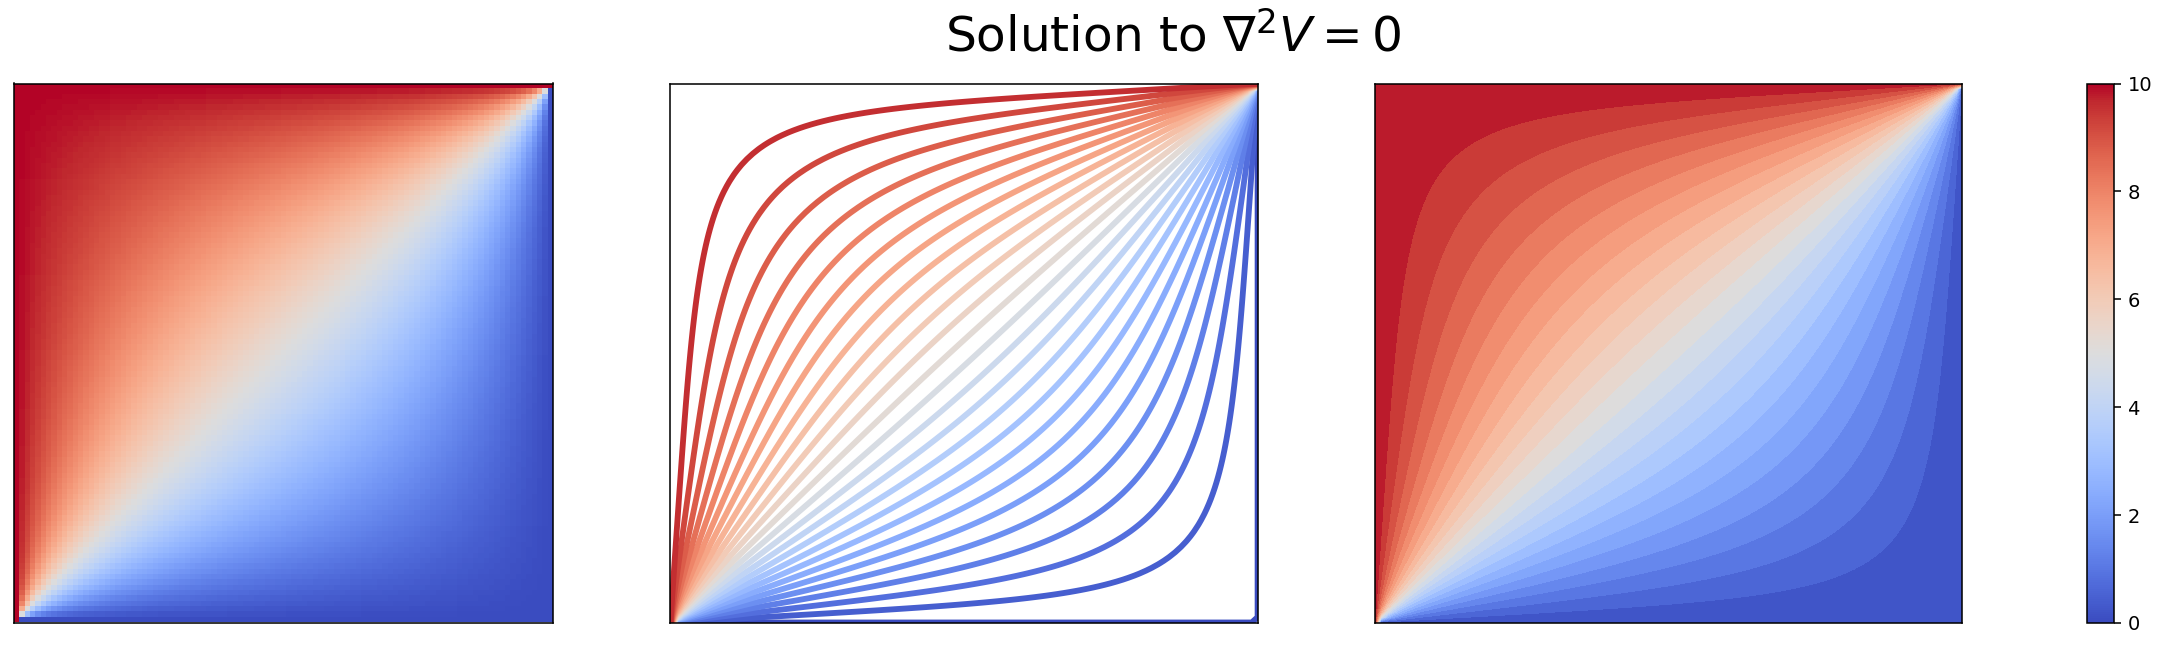

In [5]:
make_plots(phi)

Now here is the 3D interactive plot.

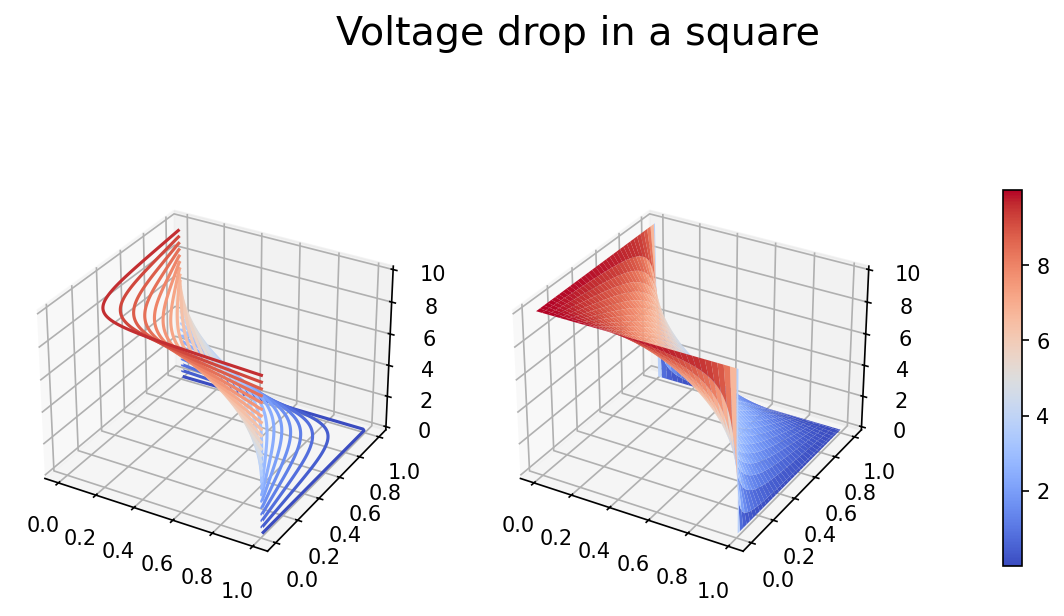

In [6]:
# to interact  with plot
# %matplotlib widget
# if it doesn't work or you just want to look at a static version use
# %matplotlib inline

XYvals = np.linspace(0, 1, len(V))
X, Y = np.meshgrid(XYvals, XYvals)

# plotting the surface and the contours
fig, ax = plt.subplots(1, 2, figsize=[10, 5], subplot_kw={"projection": "3d"}, dpi=150)
ax[0].contour(X, Y, phi, **kw)
img = ax[1].plot_surface(X, Y, phi, cmap="coolwarm")

fig.colorbar(img, ax=ax, pad=0.1, shrink=0.65)
plt.suptitle("Voltage drop in a square", size=19)
plt.show()

## Let's try using the Gauss Seidel and the cross & square method.

First the Cross and Square method

In [7]:
# Restarting the arrays
Nsquares = 100  # number of squares for each side (i.e. 100x100 total)
V = np.zeros([Nsquares + 1, Nsquares + 1])  # initialize an 100x100 array full of zeroes

V[:, 0] = 10  # left side set to 10 Volts
V[0, :] = 10  # top side set to 10 Volts
epsilon0 = 8.85e-12
a = 1 / V.size
tolerance = 1e-6


@nb.njit
def square_avg(V, i, j):
    return (V[i + 1, j] + V[i - 1, j] + V[i, j + 1] + V[i, j - 1]) / 4


@nb.njit
def cross_avg(V, i, j):
    return (V[i + 1, j + 1] + V[i + 1, j - 1] + V[i - 1, j + 1] + V[i - 1, j - 1]) / 4


@nb.njit
def cross_square(V, coeff=(0.5, 0.5)):
    assert sum(coeff) == 1, "must sum to 1"
    V = V.copy()
    xpoints, ypoints = V.shape
    delta = 1
    counter = 0
    Vprime = np.zeros_like(V)

    while delta > tolerance:
        for i in range(xpoints):
            for j in range(ypoints):

                if i == 0 or (i == xpoints - 1) or j == 0 or (j == ypoints - 1):
                    Vprime[i, j] = V[i, j]

                else:
                    Vprime[i, j] = coeff[0] * cross_avg(V, i, j) + coeff[
                        1
                    ] * square_avg(V, i, j)
                    +(a**2) * rho(i, j) / (4 * epsilon0)

        # Compute until convergence
        delta = np.max(np.abs(V - Vprime))
        # Swap the two arrays
        V, Vprime = Vprime, V

        counter += 1
        if counter == 1e5:
            break

    print("Number of iterations is", counter)

    return V, counter

Finding the best weights for the cross method

In [8]:
Iter, PHI = [], []

cross_weights = np.arange(0, 1.1, 0.1)

for w in cross_weights:
    phi, i = cross_square(V, coeff=[w, 1 - w])
    PHI.append(phi)
    Iter.append(i)

print(f"The best weight is {cross_weights[np.argmin(Iter)]}")

Number of iterations is 16806
Number of iterations is 15454
Number of iterations is 14313
Number of iterations is 13337
Number of iterations is 12492
Number of iterations is 11752
Number of iterations is 11099
Number of iterations is 10519
Number of iterations is 9999
Number of iterations is 9530
Number of iterations is 9807
The best weight is 0.9


It turns out that the best weight is `0.999` for the cross method
    

Number of iterations is 9109


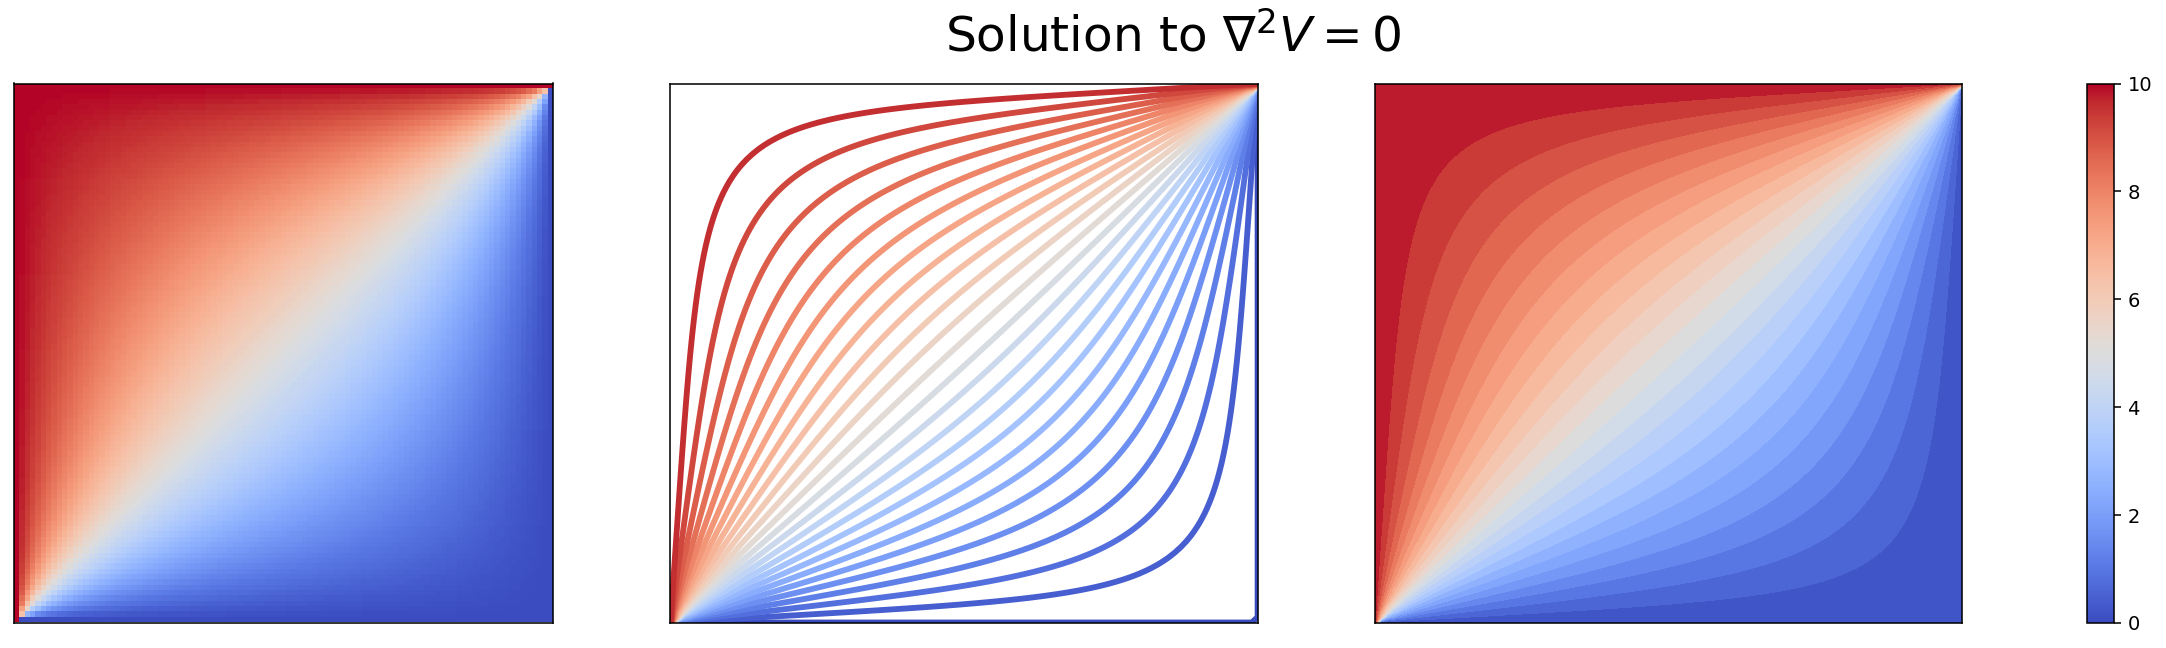

In [9]:
w = 0.999
phi, i = cross_square(V, coeff=[w, 1 - w])

make_plots(phi)

## Now Gauss-Seidel

In [10]:
@nb.njit
def Gauss_Seidel(V):
    V = V.copy()
    xpoints, ypoints = V.shape
    delta = 1
    counter = 0

    while delta > tolerance:
        delta = 0  # it has to be reset for the next round of squares
        for i in range(xpoints):
            for j in range(ypoints):
                if i != 0 and i != xpoints - 1 and j != 0 and j != ypoints - 1:

                    Vold = V[i, j]

                    V[i, j] = (
                        V[i + 1, j] + V[i - 1, j] + V[i, j + 1] + V[i, j - 1]
                    ) / 4
                    +(a**2) * rho(i, j) / (4 * epsilon0)

                    # Compute until convergence
                    delta = max([delta, abs(Vold - V[i, j])])
                    # delta = max(delta,np.abs(Vold - V[i,j]))

        counter += 1
        if counter == 1e5:
            break

    print("Number of iterations is", counter)

    return V

Number of iterations is 9081


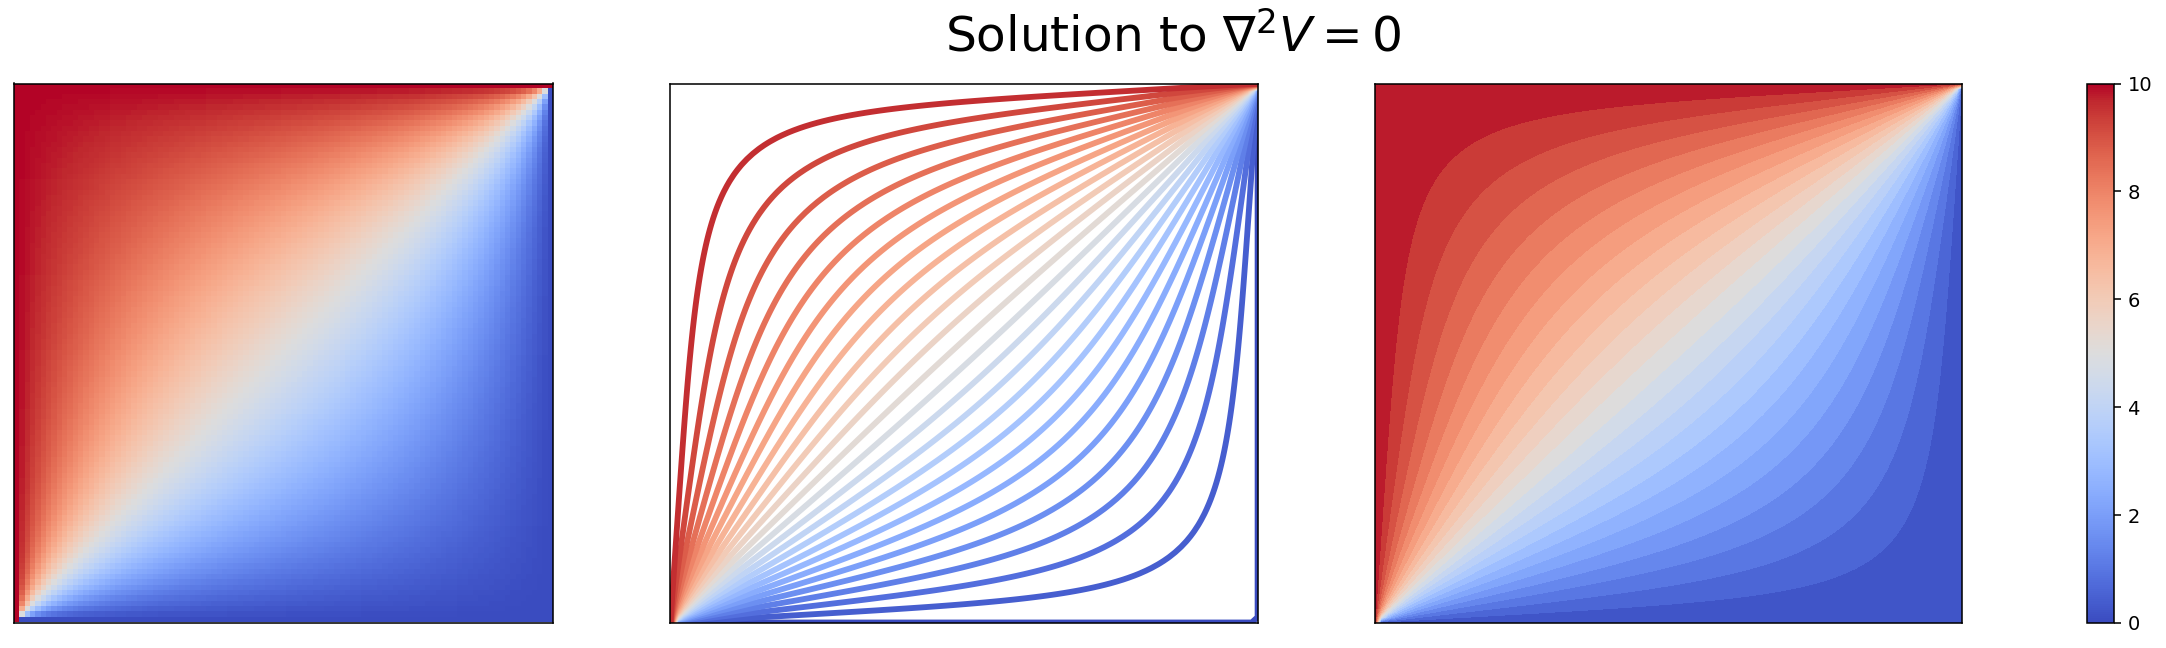

In [11]:
phi = Gauss_Seidel(V)
make_plots(phi)

## Problem 2
Use the relaxation method to calculate the potential of a two-dimensional parallel plate capacitor. You may assume that the plates are infinite in the z-direction so that it is a two dimensional calculation. I will be particularly interested in how well you reproduce the fringing field at the edges of the plates. You may assume that the plate potentials are +1 Volt for the bottom plate and -1 Volt for the top plate. Assume that the plates are separated by 1cm and are 20cm wide. Investigate how the size of your simulation relative to the width of the plates affects the fringing field. Assume the thickness of the plates is 25mm. Show plots of the equipotential contours

I first must change the boundary conditions as stated in the `relaxation` function before to match this problem.

Also, because we are now to solve the Poisson equation
$$ \nabla^2 V =- \frac{\rho}{\epsilon_0}$$

we have to adjust our function by adding a term.


Poisson's Equation takes the form

$$
\frac{\phi(x+a,y) + \phi(x-a,y) + \phi(x,y+a) + \phi(x,y-a) - 4 \phi(x,y)}{a^2} =  -\frac{\rho(x,y)}{\epsilon_0}
$$

$$
\phi(x,y)= \frac14 [\phi(x+a,y) + \phi(x-a,y) + \phi(x,y+a) + \phi(x,y-a)] + \frac{a^2}{4\epsilon_0} \rho(x,y)
$$

In [12]:
# Creating locations of the conductors
Nrows, Ncols = 100, 300
width = 200  # mm
thickness = 25  # mm
separation = 10  # mm
offset_row = (Nrows - (separation + thickness * 2)) // 2
offset_col = (Ncols - (width)) // 2
print(f"The top plate is located at x = {offset_col} and y = {offset_row}")

The top plate is located at x = 50 and y = 20


In [13]:
@nb.njit
def rho(i, j):
    """
    The charge distribution on the conductor
    """

    if (offset_row < i < offset_row + thickness) and (
        offset_col < j < offset_col + width
    ):
        return -1

    if (
        offset_row + separation + thickness
        < i
        < offset_row + separation + 2 * thickness
    ) and (offset_col < j < offset_col + width):

        return 1

    return 0

In [14]:
@nb.njit
def relaxation2(phi):
    # Setting constants
    a = 1e-6
    epsilon0 = 8.85e-12
    delta = 1
    tolerance = 1e-6
    counter = 0
    # Initializing arrays
    V = phi.copy()
    xpoints, ypoints = V.shape
    Vprime = np.zeros_like(V)

    # Main loop
    while delta > tolerance:

        for i in range(xpoints):
            for j in range(ypoints):
                if i == 0 or i == (xpoints - 1) or j == 0 or j == (ypoints - 1):
                    Vprime[i, j] = V[i, j]

                elif (offset_row < i < offset_row + thickness) and (
                    offset_col < j < offset_col + width
                ):
                    Vprime[i, j] = -1

                elif (
                    offset_row + separation + thickness
                    < i
                    < offset_row + separation + 2 * thickness
                ) and (offset_col < j < offset_col + width):
                    Vprime[i, j] = 1

                else:
                    Vprime[i, j] = (
                        V[i + 1, j] + V[i - 1, j] + V[i, j + 1] + V[i, j - 1]
                    ) / 4 + a**2 / (4 * epsilon0) * rho(i, j)

        # Compute until convergence
        delta = np.max(np.abs(V - Vprime))

        # Swap the two arrays
        V, Vprime = Vprime, V

        counter += 1
        if counter > 1e6:
            break
    print("Number of iterations is", counter)

    return V

In [15]:
#
# Creating locations of the conductors
Nrows, Ncols = 100, 300
width = 200  # mm
thickness = 25  # mm
separation = 10  # mm
offset_row = (Nrows - (separation + thickness * 2)) // 2
offset_col = (Ncols - (width)) // 2
print(f"The top plate is located at x = {offset_col} and y = {offset_row}")


V2 = np.zeros([Nrows + 1, Ncols + 1])
V2[offset_row : offset_row + thickness, offset_col : offset_col + width] = (
    -1
)  # top side set to -1 V
V2[
    offset_row + thickness + separation : offset_row + 2 * thickness + separation :,
    offset_col : offset_col + width,
] = 1  # bottom side set to 1 V
phi2 = relaxation2(V2)


def make_plots2(phi, V):

    kw = {"cmap": "coolwarm", "levels": 25, "origin": "upper"}

    plt.matshow(V, cmap="coolwarm")
    plt.colorbar(location="bottom", label="V", shrink=0.5)
    plt.title("Two infinte conducting plates", size=20, pad=50)
    plt.ylabel("Y [mm]")
    plt.xlabel("X [mm]")
    plt.show()

    plt.matshow(phi, cmap="coolwarm")
    plt.title("Solution", size=20)
    plt.colorbar(location="bottom", label="V", shrink=0.5)
    plt.show()

    plt.contourf(phi, **kw)
    plt.title("Solution")
    plt.colorbar(location="bottom", label="V")
    plt.show()

    plt.contour(phi, **kw)
    plt.title("Solution")
    plt.colorbar(location="bottom", label="V")
    plt.show()

The top plate is located at x = 50 and y = 20
Number of iterations is 4566


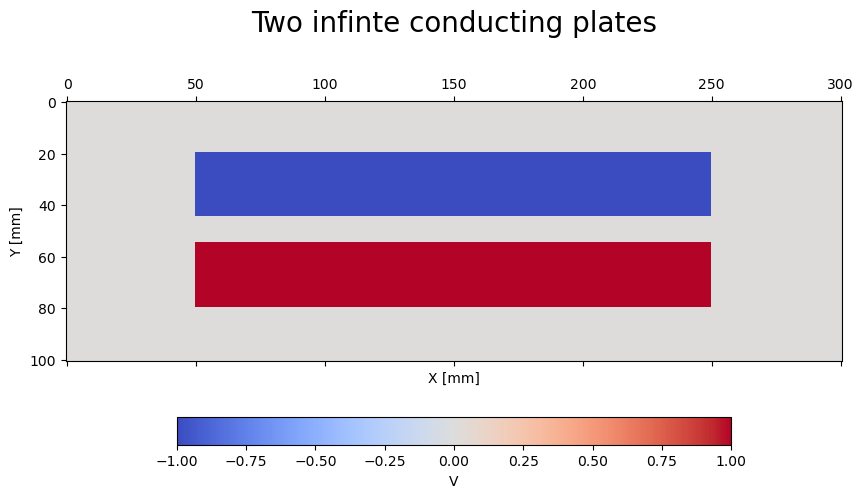

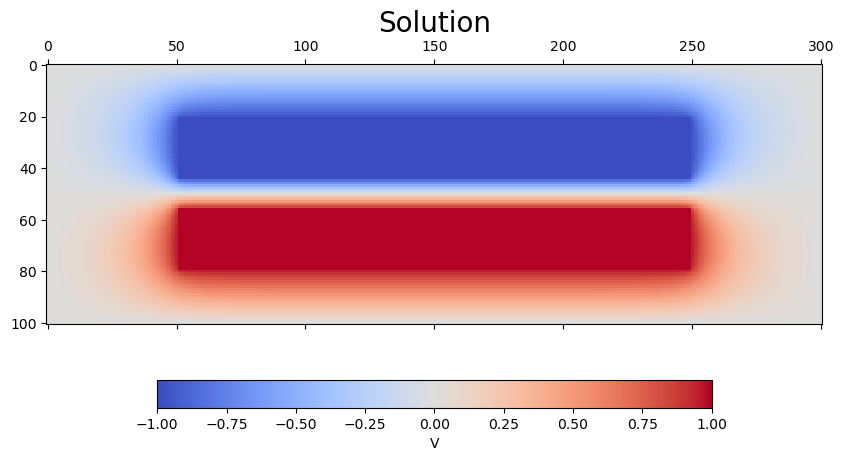

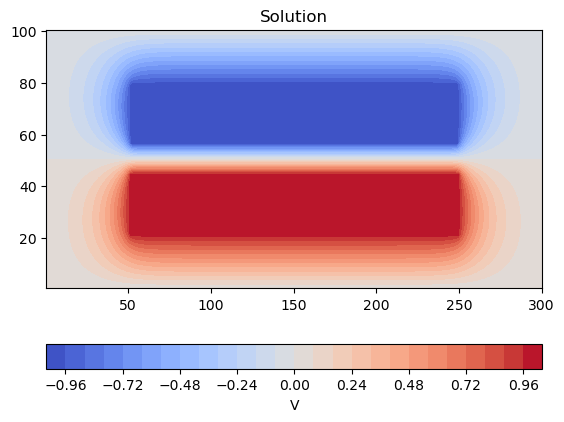

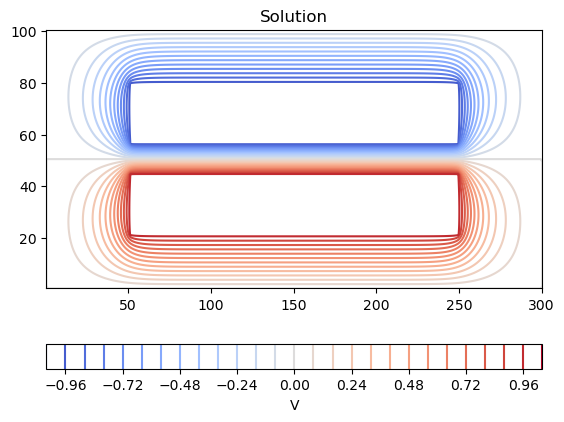

In [16]:
make_plots2(phi2, V2)

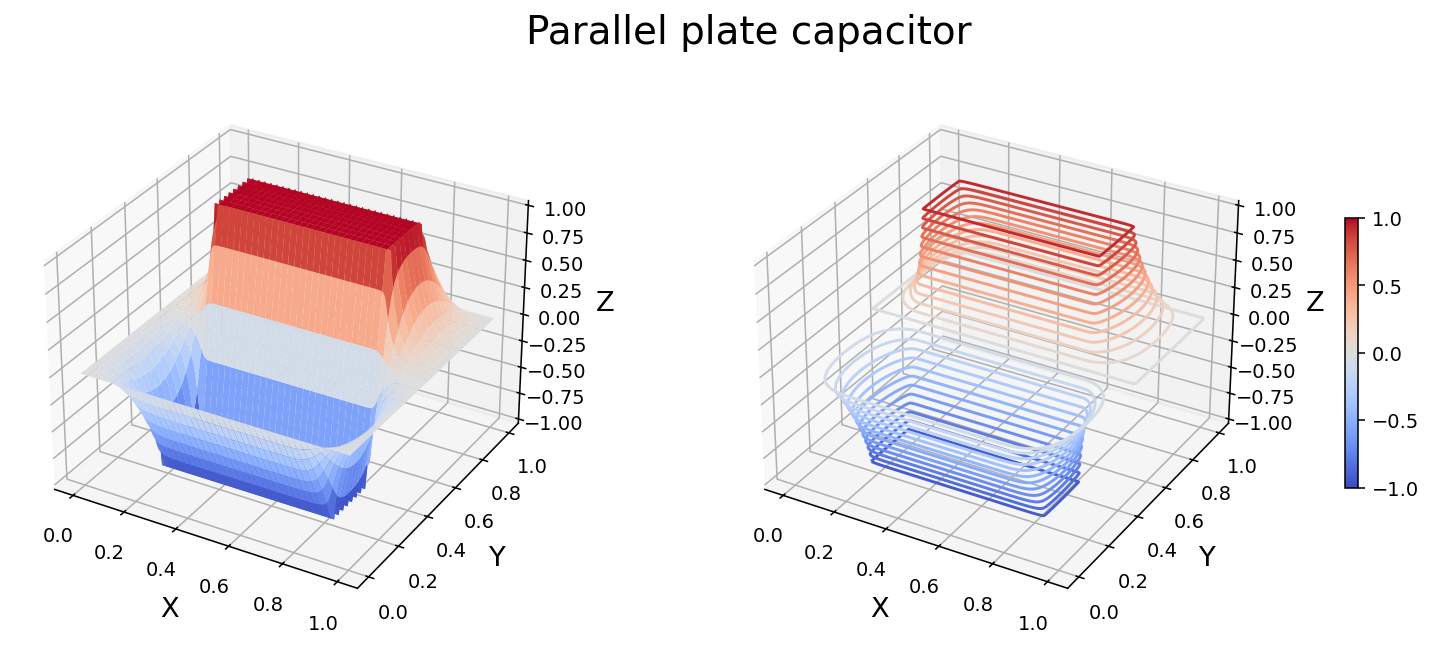

In [17]:
%matplotlib inline

y, x = V2.shape
X = np.linspace(0, 1, x)
Y = np.linspace(0, 1, y)
X, Y = np.meshgrid(X, Y)

fig, ax = plt.subplots(1, 2, figsize=[15, 5], dpi=140, subplot_kw={"projection": "3d"})

img = ax[0].plot_surface(X, Y, phi2, cmap="coolwarm")
ax[1].contour(X, Y, phi2, **kw)


kw2 = {"labelpad": 5, "size": 14}
for i in range(2):
    ax[i].set_xlabel("X", **kw2)
    ax[i].set_ylabel("Y", **kw2)
    ax[i].set_zlabel("Z", **kw2)
    ax[i].tick_params(axis="both", which="major", labelsize=10)
plt.colorbar(img, ax=ax, shrink=0.5)
plt.suptitle("Parallel plate capacitor", size=20)

plt.show()

## Now let's explore with other size of the simulation

The top plate is located at x = 50 and y = 70
Number of iterations is 22942


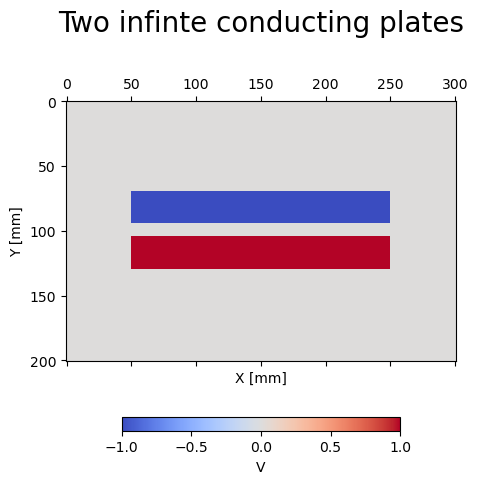

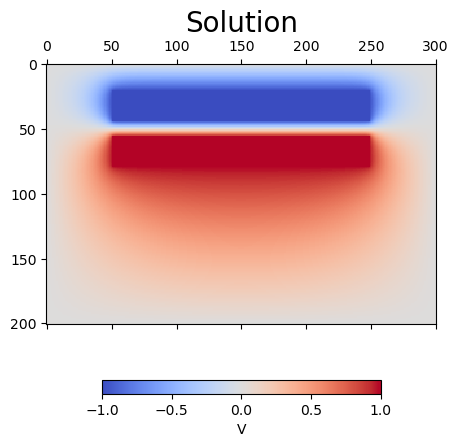

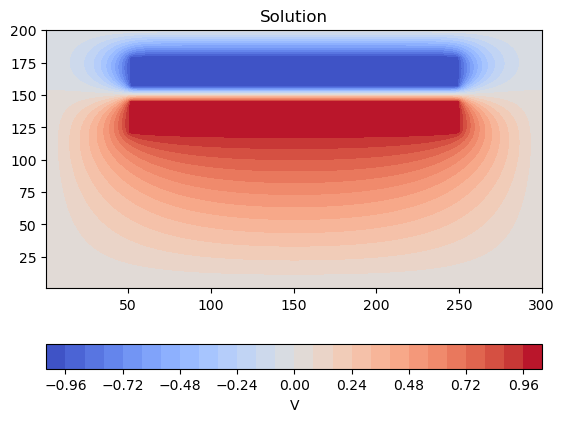

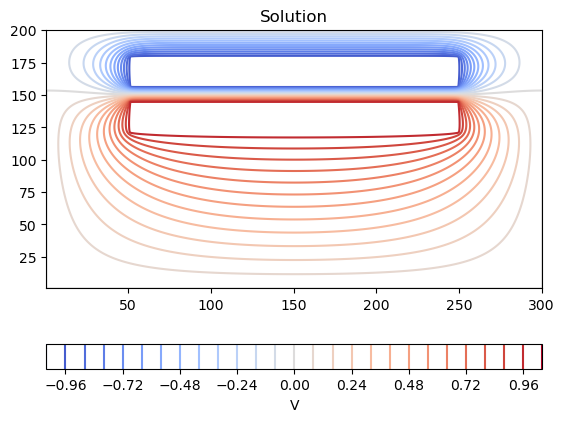

In [18]:
Nrows = 200
Ncols = 300
offset_row = (Nrows - (separation + thickness * 2)) // 2
offset_col = (Ncols - (width)) // 2
print(f"The top plate is located at x = {offset_col} and y = {offset_row}")

V2 = np.zeros([Nrows + 1, Ncols + 1])
V2[offset_row : offset_row + thickness, offset_col : offset_col + width] = (
    -1
)  # top side set to -1 V
V2[
    offset_row + thickness + separation : offset_row + 2 * thickness + separation :,
    offset_col : offset_col + width,
] = 1  # bottom side set to 1 V

phi2 = relaxation2(V2)
make_plots2(phi=phi2, V=V2);